# My Weighted Iggy

A simple `iggy`-like system, but with the notion of signed weights.

## Idea

The initial mission was to change the definition of `node_color(N, C)` to `node_color(N, C, W)`, where `W >= 0` is the weight of node `N`.

However, it's generally better to define a `Signed_W := C * W`, where L is the maximal level such that `|Signed_W| <= L`.

So, now `node_color(N, C)` becomes `node_color(N, C, Signed_W)`.

## Previous Rules

### RULE 1: Observation satisfaction

For each observed node, the model behavior must match the biological observation data:

- Where data > 1, the model should = 1;
- Where -1 <= data <= 1, the model should = 0;
- Where data < -1, the model should = -1.

### RULE 2: Justification of the change in one predecessor

For any non-input node `J` with color `C`, there must be at least one instance of `influence(J, C)` (to justify its change).

### RULE 3: Justification of zero change
A node can only exhibit zero change if it receives no or conflicting influences.

### Repair model
We add new influences to current nodes trying to rebalance the current graph if it's found inconsistent, obeying the following rules:

- Each new influence must `!= 0`
- For each node there must be at most 1 influence.

## Current Rules

### RULE 1a: Observation satisfaction

For each observed node, the model behavior must match the biological observation data.
That is, given a **tolerance threshold** `C0 >= 0`:

- Where data > 1, the model should > C0;
- Where -1 <= data <= 1, the model should -C0 <= model <= C0;
- Where data < -1, the model should < -C0.

### RULE 2a: Justification of the change in all predecessors

For any non-input node `J` with color `C`, its color is the mean of **all its precessors'** influences.

### RULE 3a: Justification of zero change
A node can only exhibit zero change if it receives no or conflicting influences **with a sum of 0**.



In [1]:
%%clingo -n 0 --project --parallel-mode 8

% Description of the signed directed graph.
node(arcA; fnr; rpsP; rpmC).

% Possible signs of an edge.
sign(-1; 1).

% Given edges and their sign.
edge(arcA, fnr, -1).
edge(arcA, rpmC, -1).
edge(fnr, rpmC, 1).
edge(fnr, rpsP, -1).

% Deduce the input nodes.
input(J) :- node(J), not influence(J, _).

% ==CHANGE: There are no real "colors" for nodes anymore.==
% We use signed weights instead.
color_level(4).
color(-L..L) :- color_level(L).

% Measurements of a node in 5 levels: -, dn, 0, up, +.
% Taking values (-2, -1, 0, 1, 2) to
% simplify description of RULE 1 below.
level(-2; -1; 0; 1; 2).

% Observed nodes and their color.
% observed(rpsP, 1).
observed(rpsP, 2).
observed(rpmC, -2).

% Define an alias for forbidden node coloring.
:- forbidden(N, C), node_color(N, C).

% Each node can only have 1 color.
1 {node_color(N, C): color(C)} :- node(N).
forbidden(N, C) :- node_color(N, D), color(C), color(D), D != C.

% Propagate effects forward.
node_color(J, C) :- node(J), color(C), not forbidden(J, C).

% ==CHANGE: RULE 1: Observation satisfaction==
% For each observed node, the model behavior must match
% the biological observation data.
% That is, given a tolerance threshold C0 >= 0:

color_tol(L/2) :- color_level(L).

% ==Where data > 1, the model should > C0;==
forbidden(N, C) :- observed(N, L), L > 1,
    color_tol(C0), color(C), C <= C0.

% ==Where -1 <= data <= 1, the model should -C0 <= model <= C0;==
forbidden(N, C) :- observed(N, L), |L| <= 1,
    color_tol(C0), color(C), |C| > C0.

% ==Where data < -1, the model should < -C0.==
forbidden(N, C) :- observed(N, L), L < -1,
    color_tol(C0), color(C), C >= -C0.

% ==CHANGE: RULE 2: Justification of the change in all predecessors==
% For any non-input node, its change must be explained by the influence
% ==of all of its predecessors in the graph:==
% ==its color is the mean of its precessors' influences.==

node_color_raw(J, S, T) :- node(J), not input(J),
    S1 = #sum{F : influence(I, J, F), F != 0},
    S2 = #sum{F : new_influence(J, F), F != 0},
    S = S1 + S2,
    T1 = #count{I : influence(I, J, F), F != 0},
    T2 = #count{F : new_influence(J, F), F != 0},
    T = T1 + T2.

% If J is influenced, then J should have the averaged color.
forbidden(J, C) :- T != 0, C != S/T, node_color_raw(J, S, T),
    color(C), color_level(L).

% If J is not influenced, then J should have color 0.
forbidden(J, C) :- not influence(J), node(J), color(C), C != 0.

% We define the influence of node i on node j as:
% influence(i, j) := sign(i) * sign(edge(i, j))
influence(I, J, R) :- edge(I, J, P), node_color(I, Q),
    R = P * Q, R != 0.
influence(J, C) :- influence(I, J, C).
influence(J) :- influence(J, C).

% RULE 3: Justification of zero change
% A node can only exhibit zero change if it receives no or conflicting
% influences with a sum of 0.
forbidden(J, 0) :- influence(J), #sum{F : influence(J, F)} != 0.

% Repair model
% Each new influence must be consistent with itself,
% and at the same time inconsistent with the other.
new_color(C) :- color(C), C != 0.
new_influence(J, C) :- not not new_influence(J, C),
    node(J), new_color(C).
{new_influence(J, C): new_color(C)} 1 :- node(J).
    
influence(J, C) :- new_influence(J, C).

% Minimize the number of new influences (fixes) added to the graph.
#minimize{ 1, (J, C) : new_influence(J, C) }.

% #show node_color_raw/3.
#show node_color/2.
% #show influence/2.
#show new_influence/2.

clingo version 5.4.0
Reading from stdin
Solving...
Progression : [1;inf]
Answer: 1
new_influence(arcA,4) new_influence(fnr,-3) new_influence(rpsP,3) node_color(arcA,4) node_color(fnr,-3) node_color(rpsP,3) node_color(rpmC,-3)
Optimization: 3
Answer: 2
new_influence(fnr,-3) node_color(arcA,0) node_color(fnr,-3) node_color(rpsP,3) node_color(rpmC,-3)
Optimization: 1
OPTIMUM FOUND

Models       : 2
  Optimum    : yes
Optimization : 1
Calls        : 1
Time         : 0.140s (Solving: 0.06s 1st Model: 0.05s Unsat: 0.00s)
CPU Time     : 0.332s
Threads      : 8        (Winner: 1)


-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)

-:75:33-36: info: operation undefined:
  (S/T)



## Result Analysis

### Key Facts

```
color_level(4).
observed(rpsP, 2).
observed(rpmC, -2).
```

### Answer 1

```
new_influence(arcA,4) new_influence(fnr,-3) new_influence(rpsP,3) node_color(arcA,4) node_color(fnr,-3) node_color(rpsP,3) node_color(rpmC,-3)
Optimization: 3
```

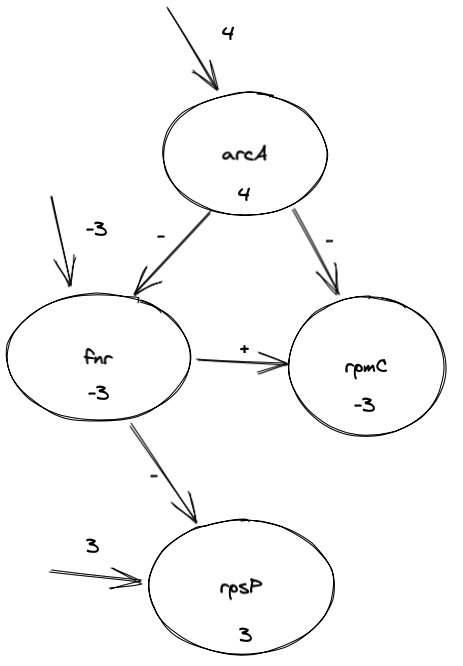

### Answer 2

```
new_influence(fnr,-3) node_color(arcA,0) node_color(fnr,-3) node_color(rpsP,3) node_color(rpmC,-3)
Optimization: 1
OPTIMUM FOUND
```

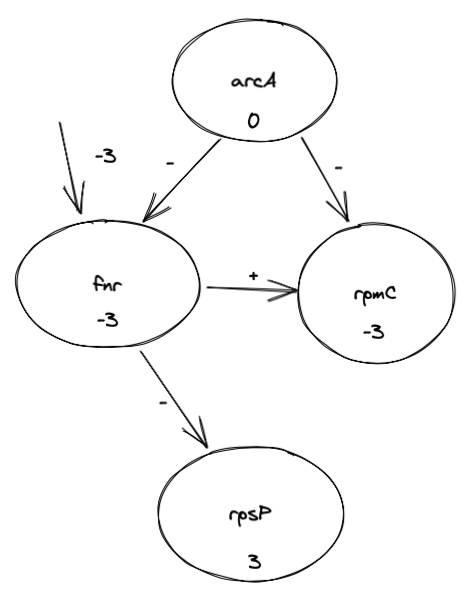